In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#import matplotlib.gridspec as gridspec
#import seaborn as sns

from sklearn.linear_model import LinearRegression
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess
import xgboost as xgb
from xgboost import XGBRegressor
from math import sqrt
from sklearn.metrics import mean_squared_log_error
import statsmodels.api as sm
import statsmodels.tsa.stattools as st

C:\Users\adeli\ProgramData\Anaconda\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


### Import Data

In [2]:
train_df = pd.read_csv("C:\\Users\\adeli\\Projects\\Kaggle\\StoreSales\\train.csv",parse_dates=['date'])
test_df = pd.read_csv("C:\\Users\\adeli\\Projects\\Kaggle\\StoreSales\\test.csv",parse_dates=['date']) 
holidays_df = pd.read_csv("C:\\Users\\adeli\\Projects\\Kaggle\\StoreSales\\holidays_events.csv",parse_dates=['date']) 
oil_df = pd.read_csv("C:\\Users\\adeli\\Projects\\Kaggle\\StoreSales\\oil.csv",parse_dates=['date']) 
stores_df = pd.read_csv("C:\\Users\\adeli\\Projects\\Kaggle\\StoreSales\\stores.csv")
transactions_df = pd.read_csv("C:\\Users\\adeli\\Projects\\Kaggle\\StoreSales\\transactions.csv",parse_dates=['date'])

### Missing Values Data

In [3]:
df = pd.concat([train_df, test_df], sort=True) #3029400
df = df.merge(oil_df, on='date', how='left')
df = df.merge(stores_df, on='store_nbr', how='left')
df = df.merge(transactions_df, on=['date', 'store_nbr'], how='left')
index = ['store_nbr', 'family', 'date']

In [4]:
print('Shape of data: \t', df.shape)

Shape of data: 	 (3029400, 12)


In [5]:
df.isnull().sum()

date                 0
family               0
id                   0
onpromotion          0
sales            28512
store_nbr            0
dcoilwtico      935550
city                 0
state                0
type                 0
cluster              0
transactions    274296
dtype: int64

In [6]:
complete_dates = df.date.unique()
df_oil_dates = pd.DataFrame(complete_dates)
df_oil_dates = df_oil_dates.rename(columns={0:'date'})

df_moving_avg_oil = df_oil_dates.merge(oil_df, on=['date'], how='left')
df_moving_avg_oil.dcoilwtico.bfill(axis ='rows', inplace=True)

df_moving_avg_oil.isnull().sum()

date          0
dcoilwtico    0
dtype: int64

C:\Users\adeli\AppData\Local\Temp\ipykernel_15940\59103484.py:1: FutureWarning: Dropping of nuisance columns in rolling operations is deprecated; in a future version this will raise TypeError. Select only valid columns before calling the operation. Dropped columns were Index(['date'], dtype='object')
  df_moving_avg_oil['moving_avg_oil'] = df_moving_avg_oil.rolling(


Text(0.5, 1.0, 'Oil Prices in Ecuador')

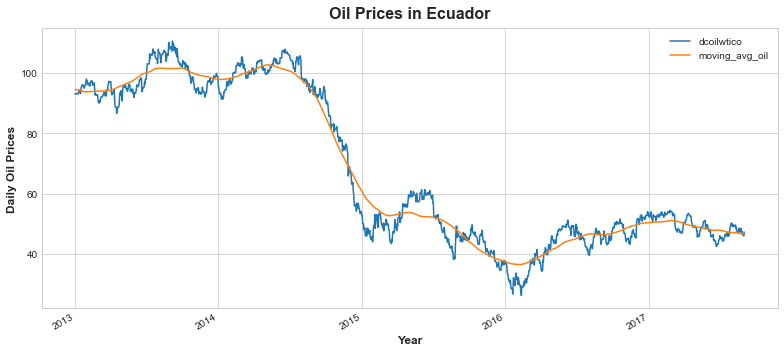

In [7]:
df_moving_avg_oil['moving_avg_oil'] = df_moving_avg_oil.rolling(
    window=180,       # Tested a couple window sizes to ensure bfill would result in zero null values
    center=True,      # puts the average at the center of the window
    min_periods=90,   # choose about half the window size
).mean()              # compute the mean

# Set Matplotlib defaults
plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True, figsize=(11, 5))
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=16,
    titlepad=10,
)

df_moving_avg_oil['Year'] = df_moving_avg_oil['date'].dt.year

df_moving_avg_oil.plot.line(x='date', y=['dcoilwtico', 'moving_avg_oil'])

plt.xlabel('Year')
plt.ylabel('Daily Oil Prices')
plt.title("Oil Prices in Ecuador")

#plt.show();

In [8]:
df = df.drop('dcoilwtico', axis=1)

df_moving_avg_oil=df_moving_avg_oil.drop(columns=['dcoilwtico','Year'])
df['date'] = pd.to_datetime(df['date'])
df['year'] = pd.DatetimeIndex(df['date']).year
df = df.merge(df_moving_avg_oil, on='date', how='left')

In [9]:
df['transactions'] = df['transactions'].replace(np.nan, int(0))
df['sales'] = df['sales'].replace(np.nan, int(0))
df.isnull().sum()
#df.dtypes
#df.columns

date              0
family            0
id                0
onpromotion       0
sales             0
store_nbr         0
city              0
state             0
type              0
cluster           0
transactions      0
year              0
moving_avg_oil    0
dtype: int64

In [10]:
def long_to_wide(df, index):
    return df.set_index(index).sort_index() #MAY NEED TO ADD .RESET_INDEX() TO THE BEGINNING DEPENDS ON DF

### Adding wage feature 

In [11]:
def is_leap(year):
    return year % 4 == 0 and (year % 100 != 0 or year % 400 == 0)

feb={0:28,1:29}
month={1:31,2:feb,3:31,4:30,5:31,6:30,7:31,8:31,9:30,10:31,11:30,12:31}

In [12]:
def get_wages(df):
    start_date = df.date.iloc[0]
    end_date = df.date.iloc[-1]
    df_date = pd.DataFrame(pd.date_range(start=start_date,end=end_date))
    df_date.rename(columns={0:'date'},inplace=True)
    wages=[]
    i=0
    for i in range(len(df_date)):
        y=df_date.date.dt.year[i]
        m=df_date.date.dt.month[i]
        d=df_date.date.dt.day[i]
        if (is_leap(y)==True and m==2):
            end_of_month=month[m][int(is_leap(y))]
        if is_leap(y)==False:
            end_of_month=month[m]
        if (d==15 or d==end_of_month):
            w=1
        else:
            w=0
        wages.append((w))
    df_date['wages'] = wages
    return df_date

In [13]:
df_wages = get_wages(df)
df = df.merge(df_wages, on='date', how='left')

### Pipeline

In [14]:
features = ['onpromotion', 'type','cluster', 'transactions', 'moving_avg_oil', 'store_nbr', 'family', 'year', 'wages']
X1 = df[['family','date','sales','store_nbr']].copy()
X1= X1.set_index('date').to_period('D')
X1 = X1.loc[:'2017-08-15']
X2_labels = df[features].copy()
y = X1.reset_index().set_index(index).sort_index().unstack(['store_nbr', 'family']).fillna(0.0).copy()
y_valid_full = (X1.drop(columns='store_nbr').groupby('date').mean().squeeze()).copy()
y_valid_full = y_valid_full.loc[:'2017-08-15']

#X1 = X1.stack(['family', 'store_nbr']).squeeze()
explore=pd.DataFrame(X1.loc[X1.family=='BABY CARE'].drop(columns=['store_nbr']).groupby('date').mean().squeeze())
explore.rolling(7, center=True).mean().plot()


In [15]:
from sklearn import preprocessing
from sklearn.preprocessing import OrdinalEncoder

le = preprocessing.LabelEncoder()
X2_cat = X2_labels.copy()
X2_cat['family'] = le.fit_transform(X2_labels.loc[:,'family'])

X2 = X2_cat.copy()
oe = OrdinalEncoder()
X2['type'] = oe.fit_transform(X2_cat[['type']])

In [16]:
# Create training data
fourier = CalendarFourier(freq='M', order=4)
dp = DeterministicProcess(
    index=y.index,
    constant=True,
    order=1,
    seasonal=True,
    additional_terms=[fourier],
    drop=True,
)
X1 = dp.in_sample()

X_fore = dp.out_of_sample(steps=16)

X1 = pd.concat([X1,X_fore])

In [17]:
holidays = holidays_df.copy()
holidays = holidays.set_index('date').to_period('D')
#Select national and regional holidays for 2017
holidays = holidays.loc[(holidays.locale.isin(['Regional','National'])) & (holidays.type.isin(['Transfer','Bridge','Holiday'])) ]
holidays = holidays.loc[(holidays.transferred == False)]
holidays = holidays.loc['2013-01-01':'2017-08-31',:]
print('Shape of holidays: \t', holidays.shape)
holidays.reset_index(inplace=True)
holidays = holidays.loc[:,['date','type','description']] 

Shape of holidays: 	 (72, 5)


In [18]:
i = 0
split_description = dict()
d_index = []
types=['Transfer','Bridge']

for i in range(len(holidays)):
    if (holidays.type[i] in types):
        s = holidays.loc[i, 'description']
        split_description[i] = s.split(maxsplit=1)[1]
        d_index.append(i)
#print(d_index)

In [19]:
i = 0
holidays_split = pd.DataFrame(columns = ['date', 'description'], index=range(len(holidays)))
for i in holidays.index:
    holidays_split['date'][i] = holidays['date'][i]
    if i in d_index:
        holidays_split['description'][i] = split_description[i]
    else:
        holidays_split['description'][i] =holidays['description'][i]

In [20]:
X_holidays = pd.get_dummies(holidays_split['description'])
X_holidays.index = holidays_split.date
#X1.reset_index()
X1 = X1.join(X_holidays).fillna(0.0)

### Pipeline

In [58]:
#X1.to_csv("C:\\Users\\adeli\\Projects\\Kaggle\\StoreSales\\X1.csv", index=True)
#X2.to_csv("C:\\Users\\adeli\\Projects\\Kaggle\\StoreSales\\X2.csv", index=True)
#df.to_csv("C:\\Users\\adeli\\Projects\\Kaggle\\StoreSales\\df.csv", index=True)
#y.to_csv("C:\\Users\\adeli\\Projects\\Kaggle\\StoreSales\\y.csv", index=True)

In [21]:
class BoostedHybrid:
    def __init__(self, model_1, model_2):
        self.model_1 = model_1
        self.model_2 = model_2
        self.y_columns = None #Don't store column names

In [42]:
def fit(self, X_1, X_2, y):
    self.model_1.fit(X_1, y)
    
    y_fit = pd.DataFrame(
    self.model_1.predict(X_1),
    index = X_1.index,
    columns = y.columns)
    
    #compuing residuals
    y_resid = y - y_fit
    y_resid = y_resid.stack(['store_nbr', 'family']).squeeze()
    
    #fit model 2 on residuals
    self.model_2.fit(X_2, y_resid)
    
    self.y_columns = y.columns #saving column names for predct method
    
    return y_fit
BoostedHybrid.fit = fit #adding fit method to class

In [23]:
def predict(self, X_1, X_2):
    y_pred = pd.DataFrame(
    self.model_1.predict(X_1),
    index = X_1.index, columns=self.y_columns)
    
    y_pred1 = y_pred.stack(['store_nbr', 'family']).squeeze()
    y_pred2 = self.model_2.predict(X_2)
    
    y_pred = pd.DataFrame(data=y_pred2, index=y_pred1.index, columns=['y_pred2'])
    y_pred['y_pred1'] = y_pred1
    y_pred['y_preds'] = y_pred['y_pred1'] + y_pred['y_pred2']    
    return y_pred

BoostedHybrid.predict = predict #adding predict method to class

In [24]:
model = BoostedHybrid(
    model_1 = LinearRegression(fit_intercept=False),
    model_2 = XGBRegressor())

In [25]:
y.shape

(1684, 1782)

In [43]:
y_train, y_valid = y[:"2017-07-01"], y["2017-07-02":'2017-08-15']
X1_train, X1_valid = X1[: "2017-07-01"], X1["2017-07-02":'2017-08-15']
X2_train, X2_valid = X2[: 2920698], X2[2920699:3000889]
y_valid = y_valid.stack(['store_nbr', 'family']).reset_index().drop(columns='store_nbr').groupby('date').mean().squeeze()

y_fit = model.fit(X1_train, X2_train, y_train)
#y_pred = model.predict(X1_valid, X2_valid)
#y_avg_pred = y_pred['y_preds'].reset_index().drop(columns=['store_nbr','family']).rename(columns={'level_0':'date'}).groupby('date').mean()

#rmse = sqrt(mean_squared_log_error(y_avg_pred, y_valid))
#print('rmse:', rmse)

C:\Users\adeli\ProgramData\Anaconda\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


KeyboardInterrupt: 

In [ ]:
y_fit.shape

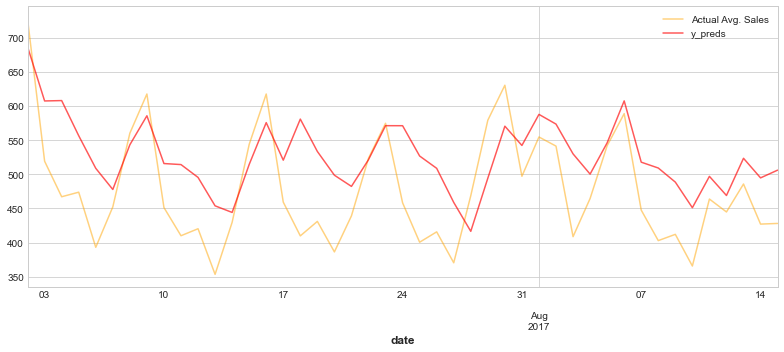

In [28]:
ax = y_valid.plot(color='orange', alpha=0.5, label='Actual Avg. Sales')
y_avg_pred.plot(ax=ax, color='red', alpha=0.65, label='Predicted Sales')
ax.legend()

In [32]:
rmse = sqrt(mean_squared_log_error(y_avg_pred['y_preds'], y_valid))
print('rmse:', rmse)

rmse: 0.16182816535997227


In [36]:
df_fam_supplies

date
2013-01-01     0.000000
2013-01-02     0.000000
2013-01-03     0.000000
2013-01-04     0.000000
2013-01-05     0.000000
                ...    
2017-08-11    65.240741
2017-08-12    67.481481
2017-08-13    68.851852
2017-08-14    52.333333
2017-08-15    46.851852
Freq: D, Name: sales, Length: 1684, dtype: float64

In [ ]:
ax = y_valid_full.plot(color='orange', alpha=0.45, label='2017 Actual Avg. Sales')
y_avg_pred['y_preds'].plot(ax=ax, color='red', alpha=0.5, label='2017 Predicted Sales')
y_fit.plot(ax=ax, color='teal', alpha=0.5, label='Predicted Sales')
ax.axvline(x='2017-07-01', ymin=-400, ymax=600, color='teal')
ax.legend()

C:\Users\adeli\anaconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\adeli\anaconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations. 
  fig.canvas.print_figure(bytes_io, **kw)


In [ ]:
X1_holdout = X1['2017-08-16':]
X2_holdout = X2[3000888:]
y_submit = pd.DataFrame(model.predict(X1_holdout, X2_holdout))


In [ ]:
ax = y_valid_full.plot(color='orange', alpha=0.45, label='2017 Actual Avg. Sales')
y_avg_pred.plot(ax=ax, color='red', alpha=0.5, label='2017 Predicted Sales')
y_fit.plot(ax=ax, color='teal', alpha=0.5, label='Predicted Sales')
y_submit.plot(ax=ax, color='blue', alpha=0.5, label='2017 Predicted Sales')
ax.axvline(x='2017-07-01', ymin=-400, ymax=600, color='teal')
ax.legend()

In [ ]:
y_submit
#y_submit = y_submit.join(test_df['id'])
y_submit = y_submit.join(test_df.id)#.reindex(columns=['id', 'sales'])
#y_submit.to_csv('submission.csv', index=False)

In [ ]:
y_submit

In [ ]:
test_df